In [95]:
pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl

ERROR: wordcloud-1.3.2-cp36-cp36m-win_amd64.whl is not a supported wheel on this platform.
Note: you may need to restart the kernel to use updated packages.


In [96]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [97]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rongyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
pip install PrettyTable

Note: you may need to restart the kernel to use updated packages.


In [219]:
#Libraries

import re
import string
import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
from collections import Counter
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WordPunctTokenizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import os
import glob
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import rcParams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import classification_report, roc_auc_score,roc_curve, auc
import warnings
warnings.filterwarnings("ignore")


# Data Processing

In [139]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tok = WordPunctTokenizer()

# remove @ mentions from IMDB movie reviews
pat1 = r'@[A-Za-z0-9_]+'

# remove URL links from IMDB movie reviews
pat2 = r'https?://[^ ]+'
www_pat = r'www.[^ ]+'

combined_pat = r'|'.join((pat1, pat2))

#remove hashtag / numbers from IMDB movie reviews
pat3 = r'[^a-zA-Z]'

#negation handling
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "hasn't":"has not","haven't":"have not","hadn't":"had not",
                "don't":"do not", "doesn't":"does not","didn't":"did not","won't":"will not",
                "wouldn't":"would not", "can't":"can not","couldn't":"could not","shouldn't":"should not",
                "mightn't":"might not", "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

#Defining data cleaning function
With above five data cleaning task, I will first define data cleaning function, and then will be applied to the whole dataset. Tokenization, stemming/lemmatization, stop words will be dealt with later stage when creating matrix with either count vectorizer or Tfidf vectorizer.

In [140]:
def  IMDB_movie_reviews_cleaner(text):
    #Data Preparation: HTML decoding
    soup = BeautifulSoup(text, 'lxml')
    no_html = soup.get_text()
    
    #Data Preparation: ‘@’mention & URL links
    stripped = re.sub(combined_pat, '', no_html)
    try:
        #Data Preparation: UTF-8 BOM (Byte Order Mark)
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    clean = re.sub(www_pat, '', clean)
    
    # will replace # by space
    letters_only = re.sub(pat3, " ", clean)
    
    # converting all into lower case
    lower_case = letters_only.lower()
    
    # converting words like isn't to is not
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(neg_handled) if len(x) > 1]
    
    # join the words
    return (" ".join(words)).strip()

Training Dataset - Positive

In [141]:
os.mkdir('/Users/rongyu/Downloads/aclImdb/train/pos/Clean_Data')
dir_path="/Users/rongyu/Downloads/aclImdb/train/pos/"
clean_dir_path =os.listdir(dir_path)
lines=[]
for i in clean_dir_path:
    if os.path.isfile(dir_path+i):
        with open(dir_path+i,"r",encoding="utf-8", errors='ignore') as filedata:
            single_file = filedata.readlines()
        with open(dir_path+"Clean_Data/"+i,"w+") as filedir:
            for l in single_file:
                clean_file = IMDB_movie_reviews_cleaner(l)            
                filedir.write(clean_file)

Saving cleaned data as csv

In [142]:
clean_dir_path="/Users/rongyu/Downloads/aclImdb/train/pos/Clean_Data"
all_dir_path = glob.glob(clean_dir_path+'/*.*')
for i in all_dir_path:
    with open(i, "rb") as data_of_files:
        data_in_lines=data_of_files.readlines()
        file=open("clean_train__positive_reviews.csv", "a", encoding="utf8")
        file.write(str(data_in_lines))
        file.write("\n")
        file.close()

In [143]:
cols = ['IMDB_Movie_Reviews','Class']
file1=pd.read_csv("clean_train__positive_reviews.csv",header=None, names=cols)
file1['Class']='positive'

In [144]:
file1

,IMDB_Movie_Reviews,Class
0,[b'for movie that gets no respect there sure a...,positive
1,[b'bizarre horror movie filled with famous fac...,positive
2,[b'solid if unremarkable film matthau as einst...,positive
3,[b'it strange feeling to sit alone in theater ...,positive
4,[b'you probably all already know this by now b...,positive
...,...,...
12495,[b'about year ago finally gave up on american ...,positive
12496,[b'when saw the elaborate dvd box for this and...,positive
12497,[b'last november had chance to see this film a...,positive
12498,[b'great movie loved it great editing and use ...,positive


Traning Dataset - Negative

In [145]:
os.mkdir('/Users/rongyu/Downloads/aclImdb/train/neg/Clean_Data')
dir_path="/Users/rongyu/Downloads/aclImdb/train/neg/"
clean_dir_path =os.listdir(dir_path)
lines=[]
for i in clean_dir_path:
    if os.path.isfile(dir_path+i):
        with open(dir_path+i,"r",encoding="utf-8", errors='ignore') as filedata:
            single_file = filedata.readlines()
        with open(dir_path+"Clean_Data/"+i,"w+") as filedir:
            for l in single_file:
                clean_file = IMDB_movie_reviews_cleaner(l)            
                filedir.write(clean_file)

Saving cleaned data as csv

In [146]:
clean_dir_path="/Users/rongyu/Downloads/aclImdb/train/neg/Clean_Data"
all_dir_path = glob.glob(clean_dir_path+'/*.*')
for i in all_dir_path:
    with open(i, "rb") as data_of_files:
        data_in_lines=data_of_files.readlines()
        file=open("clean_train_negative_reviews.csv", "a", encoding="utf8")
        file.write(str(data_in_lines))
        file.write("\n")
        file.close()

In [147]:
cols = ['IMDB_Movie_Reviews','Class']
file2=pd.read_csv("clean_train_negative_reviews.csv",header=None, names=cols)
file2['Class']='negative'

In [148]:
file2

,IMDB_Movie_Reviews,Class
0,[b'working with one of the best shakespeare so...,negative
1,[b'well tremors the original started off in an...,negative
2,[b'ouch this one was bit painful to sit throug...,negative
3,[b've seen some crappy movies in my life but t...,negative
4,[b'carriers follows the exploits of two guys a...,negative
...,...,...
12495,[b'my comments may be bit of spoiler for what ...,negative
12496,[b'the saucy misadventures of four au pairs wh...,negative
12497,[b'oh those italians assuming that movies abou...,negative
12498,[b'eight academy nominations it beyond belief ...,negative


In [149]:
Train =pd.concat([file1,file2])
Train.shape

(25000, 2)

Testing Dataset - Positive

In [150]:
os.mkdir('/Users/rongyu/Downloads/aclImdb/test/pos/Clean_Data')
dir_path="/Users/rongyu/Downloads/aclImdb/test/pos/"
clean_dir_path =os.listdir(dir_path)
lines=[]
for i in clean_dir_path:
    if os.path.isfile(dir_path+i):
        with open(dir_path+i,"r",encoding="utf-8", errors='ignore') as filedata:
            single_file = filedata.readlines()
        with open(dir_path+"Clean_Data/"+i,"w+") as filedir:
            for l in single_file:
                clean_file = IMDB_movie_reviews_cleaner(l)            
                filedir.write(clean_file)

Saving cleaned data as csv

In [151]:
clean_dir_path="/Users/rongyu/Downloads/aclImdb/test/pos/Clean_Data"
all_dir_path = glob.glob(clean_dir_path+'/*.*')
for i in all_dir_path:
    with open(i, "rb") as data_of_files:
        data_in_lines=data_of_files.readlines()
        file=open("clean_test_positive_reviews.csv", "a", encoding="utf8")
        file.write(str(data_in_lines))
        file.write("\n")
        file.close()

In [152]:
cols = ['IMDB_Movie_Reviews','Class']
file3=pd.read_csv("clean_test_positive_reviews.csv",header=None, names=cols)
file3['Class']='positive'

In [153]:
file3

,IMDB_Movie_Reviews,Class
0,[b'based on an actual story john boorman shows...,positive
1,[b'this is gem as film four production the ant...,positive
2,[b'really like this show it has drama romance ...,positive
3,[b'this is the best experience disney has at t...,positive
4,[b'of the korean movies ve seen only three had...,positive
...,...,...
12495,[b'this movie is certainly well constructed be...,positive
12496,[b'nice to see comedy for grown ups masterfull...,positive
12497,[b'jean renoir homage to the paris of the late...,positive
12498,[b'what are the movies mean what are movies ma...,positive


Testing Dataset - Negative

In [154]:
os.mkdir('/Users/rongyu/Downloads/aclImdb/test/neg/Clean_Data')
dir_path="/Users/rongyu/Downloads/aclImdb/test/neg/"
clean_dir_path =os.listdir(dir_path)
lines=[]
for i in clean_dir_path:
    if os.path.isfile(dir_path+i):
        with open(dir_path+i,"r",encoding="utf-8", errors='ignore') as filedata:
            single_file = filedata.readlines()
        with open(dir_path+"Clean_Data/"+i,"w+") as filedir:
            for l in single_file:
                clean_file = IMDB_movie_reviews_cleaner(l)            
                filedir.write(clean_file)

Saving cleaned data as csv

In [155]:
clean_dir_path="/Users/rongyu/Downloads/aclImdb/test/neg/Clean_Data"
all_dir_path = glob.glob(clean_dir_path+'/*.*')
for i in all_dir_path:
    with open(i, "rb") as data_of_files:
        data_in_lines=data_of_files.readlines()
        file=open("clean_test_negative_reviews.csv", "a", encoding="utf8")
        file.write(str(data_in_lines))
        file.write("\n")
        file.close()

In [156]:
cols = ['IMDB_Movie_Reviews','Class']
file4=pd.read_csv("clean_test_negative_reviews.csv",header=None, names=cols)
file4['Class']='negative'

In [157]:
file4

,IMDB_Movie_Reviews,Class
0,[b'alan rickman emma thompson give good perfor...,negative
1,[b'have seen this movie and did not care for t...,negative
2,[b'in los angeles the alcoholic and lazy hank ...,negative
3,[b'this film is bundled along with gli fumavan...,negative
4,[b'only comment on really very good films and ...,negative
...,...,...
12495,[b'with actors like depardieu and richard it i...,negative
12496,[b'if you like to get couple of fleeting glimp...,negative
12497,[b'when something can be anything you want it ...,negative
12498,[b'had heard good things about states of grace...,negative


In [158]:
Test=pd.concat([file3,file4])
Test.shape

(25000, 2)

In [159]:
WholeData=pd.concat([Train,Test])
WholeData.shape

(50000, 2)

Extract features from the input file

In [160]:
WholeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   IMDB_Movie_Reviews  50000 non-null  object
 1   Class               50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [161]:
WholeData[WholeData.isnull().any(axis=1)]

,IMDB_Movie_Reviews,Class


In [162]:
np.sum(WholeData.isnull().any(axis=1))

0

In [163]:
WholeData.columns

Index(['IMDB_Movie_Reviews', 'Class'], dtype='object')

In [164]:
WholeData['IMDB_Movie_Reviews']=WholeData['IMDB_Movie_Reviews'].str.lower()

In [165]:
WholeData['IMDB_Movie_Reviews']

0        [b'for movie that gets no respect there sure a...
1        [b'bizarre horror movie filled with famous fac...
2        [b'solid if unremarkable film matthau as einst...
3        [b'it strange feeling to sit alone in theater ...
4        [b'you probably all already know this by now b...
                               ...                        
12495    [b'with actors like depardieu and richard it i...
12496    [b'if you like to get couple of fleeting glimp...
12497    [b'when something can be anything you want it ...
12498    [b'had heard good things about states of grace...
12499    [b'well this movie actually did have one redee...
Name: IMDB_Movie_Reviews, Length: 50000, dtype: object

In [166]:
WholeData['Class'].unique()

array(['positive', 'negative'], dtype=object)

In [167]:
WholeData['Class'].value_counts()

positive    25000
negative    25000
Name: Class, dtype: int64

Visualization (Distribution of Class) - 50% positive & 50% negative

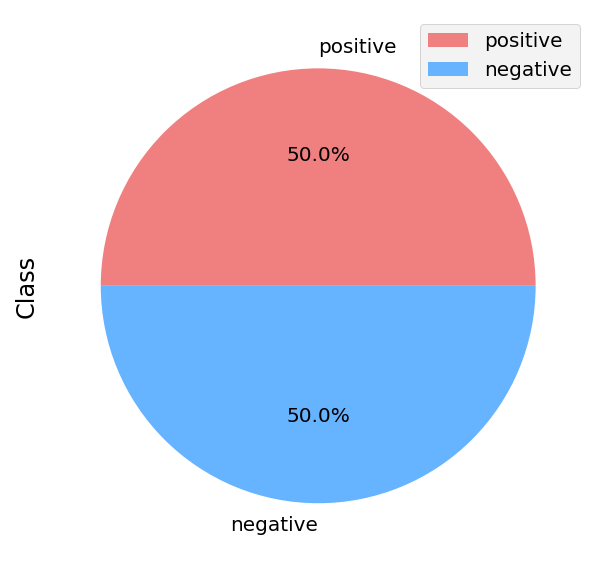

In [168]:
WholeData['Class'].value_counts().head(3).plot(kind = 'pie', autopct='%1.1f%%', figsize=(5, 5),colors=['lightcoral', '#66b3ff']).legend()

In [169]:
tok = RegexpTokenizer(r'\w+')
WholeData['IMDB_Movie_Reviews'] = WholeData['IMDB_Movie_Reviews'].apply(tok.tokenize)

In [170]:
WholeData['IMDB_Movie_Reviews']

0        [b, for, movie, that, gets, no, respect, there...
1        [b, bizarre, horror, movie, filled, with, famo...
2        [b, solid, if, unremarkable, film, matthau, as...
3        [b, it, strange, feeling, to, sit, alone, in, ...
4        [b, you, probably, all, already, know, this, b...
                               ...                        
12495    [b, with, actors, like, depardieu, and, richar...
12496    [b, if, you, like, to, get, couple, of, fleeti...
12497    [b, when, something, can, be, anything, you, w...
12498    [b, had, heard, good, things, about, states, o...
12499    [b, well, this, movie, actually, did, have, on...
Name: IMDB_Movie_Reviews, Length: 50000, dtype: object

Removing Stopwords

In [171]:
stopwords_list = stopwords.words('english')

In [172]:
len(stopwords_list)

179

In [173]:
WholeData['IMDB_Movie_Reviews']=WholeData['IMDB_Movie_Reviews'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [175]:
WholeData['IMDB_Movie_Reviews']

0        [b, movie, gets, respect, sure, lot, memorable...
1        [b, bizarre, horror, movie, filled, famous, fa...
2        [b, solid, unremarkable, film, matthau, einste...
3        [b, strange, feeling, sit, alone, theater, occ...
4        [b, probably, already, know, additional, episo...
                               ...                        
12495    [b, actors, like, depardieu, richard, really, ...
12496    [b, like, get, couple, fleeting, glimpses, cle...
12497    [b, something, anything, want, mean, bound, re...
12498    [b, heard, good, things, states, grace, came, ...
12499    [b, well, movie, actually, one, redeeming, qua...
Name: IMDB_Movie_Reviews, Length: 50000, dtype: object

Data Visualization

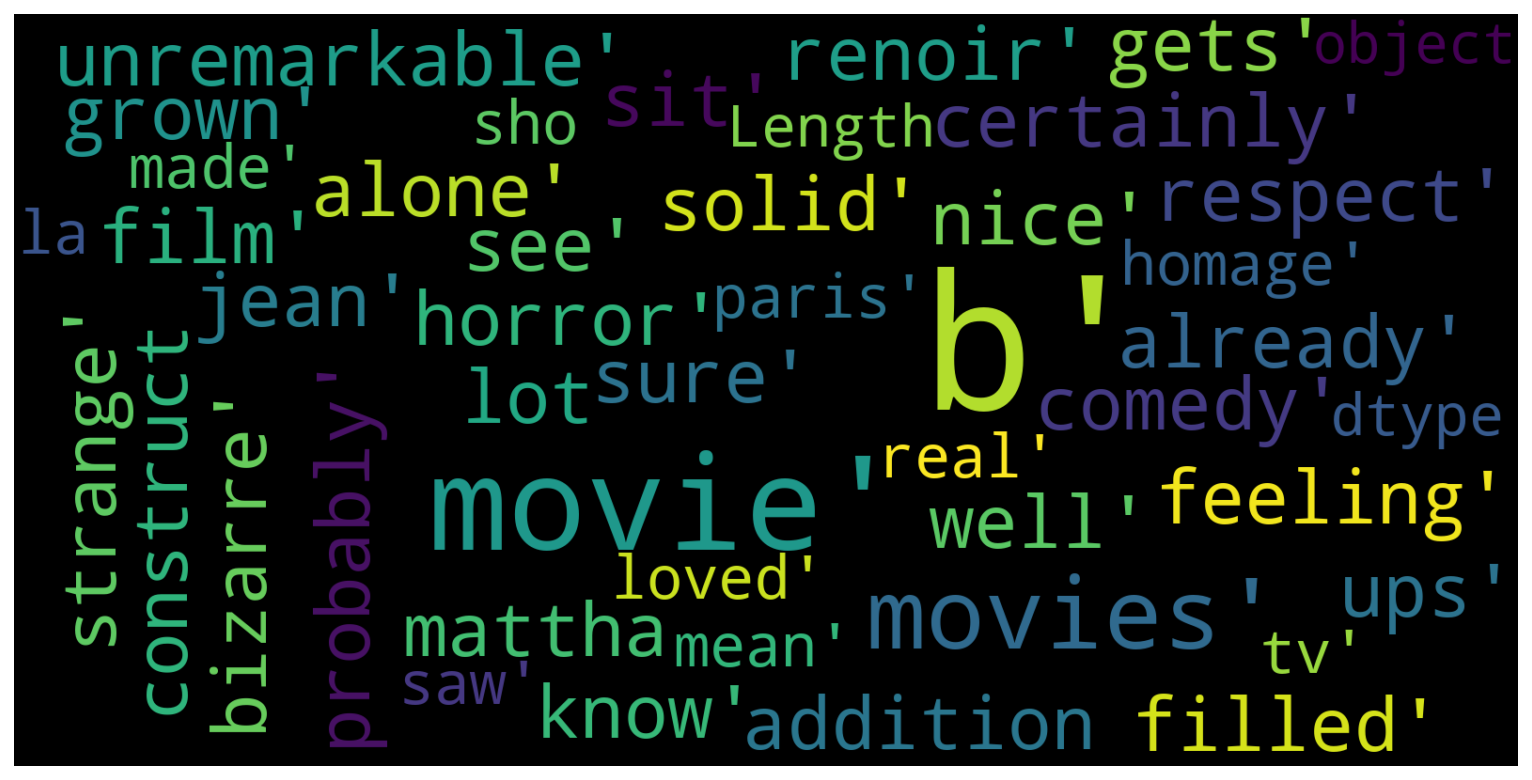

In [176]:
WholeData1=WholeData[WholeData['Class']=='positive']
pos =WholeData1['IMDB_Movie_Reviews']
pos_string = []
for t in pos:
    pos_string.append(t)
pos_string = pd.Series(pos_string).map(str)
pos_string=str(pos_string)


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

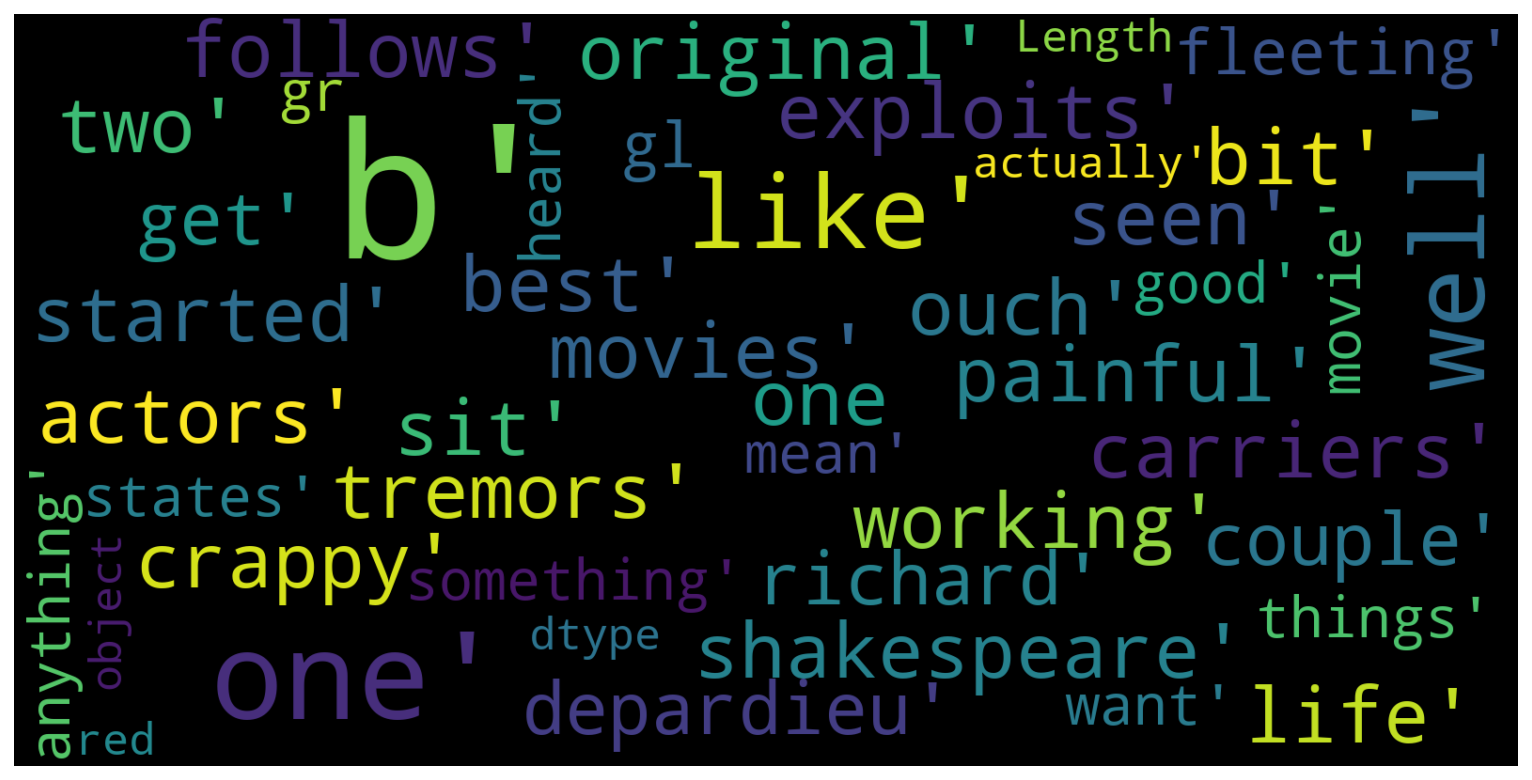

In [177]:
WholeData2=WholeData[WholeData['Class']=='negative']
neg =WholeData2['IMDB_Movie_Reviews']
neg_string = []
for t in neg:
    neg_string.append(t)
neg_string = pd.Series(neg_string).map(str)
neg_string=str(neg_string)

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [178]:
allwords = [word for tokens in WholeData['IMDB_Movie_Reviews'] for word in tokens]
Vocab = sorted(list(set(allwords)))
print("total %s words , with a vocabulary size of %s" % (len(allwords), len(Vocab)))

total 5939504 words , with a vocabulary size of 101070


Create Frequency Distribution of all words

In [179]:
counter = Counter(allwords)
counter.most_common(30)

[('movie', 87931),
 ('film', 79673),
 ('one', 53585),
 ('b', 50000),
 ('like', 40156),
 ('good', 29736),
 ('time', 25099),
 ('even', 24854),
 ('would', 24599),
 ('story', 23110),
 ('really', 23090),
 ('see', 23020),
 ('well', 21260),
 ('much', 19316),
 ('bad', 18459),
 ('get', 18415),
 ('people', 18181),
 ('great', 18137),
 ('also', 17972),
 ('first', 17575),
 ('made', 16150),
 ('make', 15892),
 ('way', 15643),
 ('could', 15563),
 ('movies', 15300),
 ('characters', 14444),
 ('think', 14334),
 ('watch', 13939),
 ('character', 13899),
 ('films', 13750)]

In [180]:
countedwords = Counter(allwords)

words = []
counts = []
for letter, count in countedwords.most_common(30):
    words.append(letter)
    counts.append(count)

Movie Reviews Tokens Visualisation:
Let’s see how the movie reviews tokens and their frequencies look like on a plot.

<BarContainer object of 30 artists>

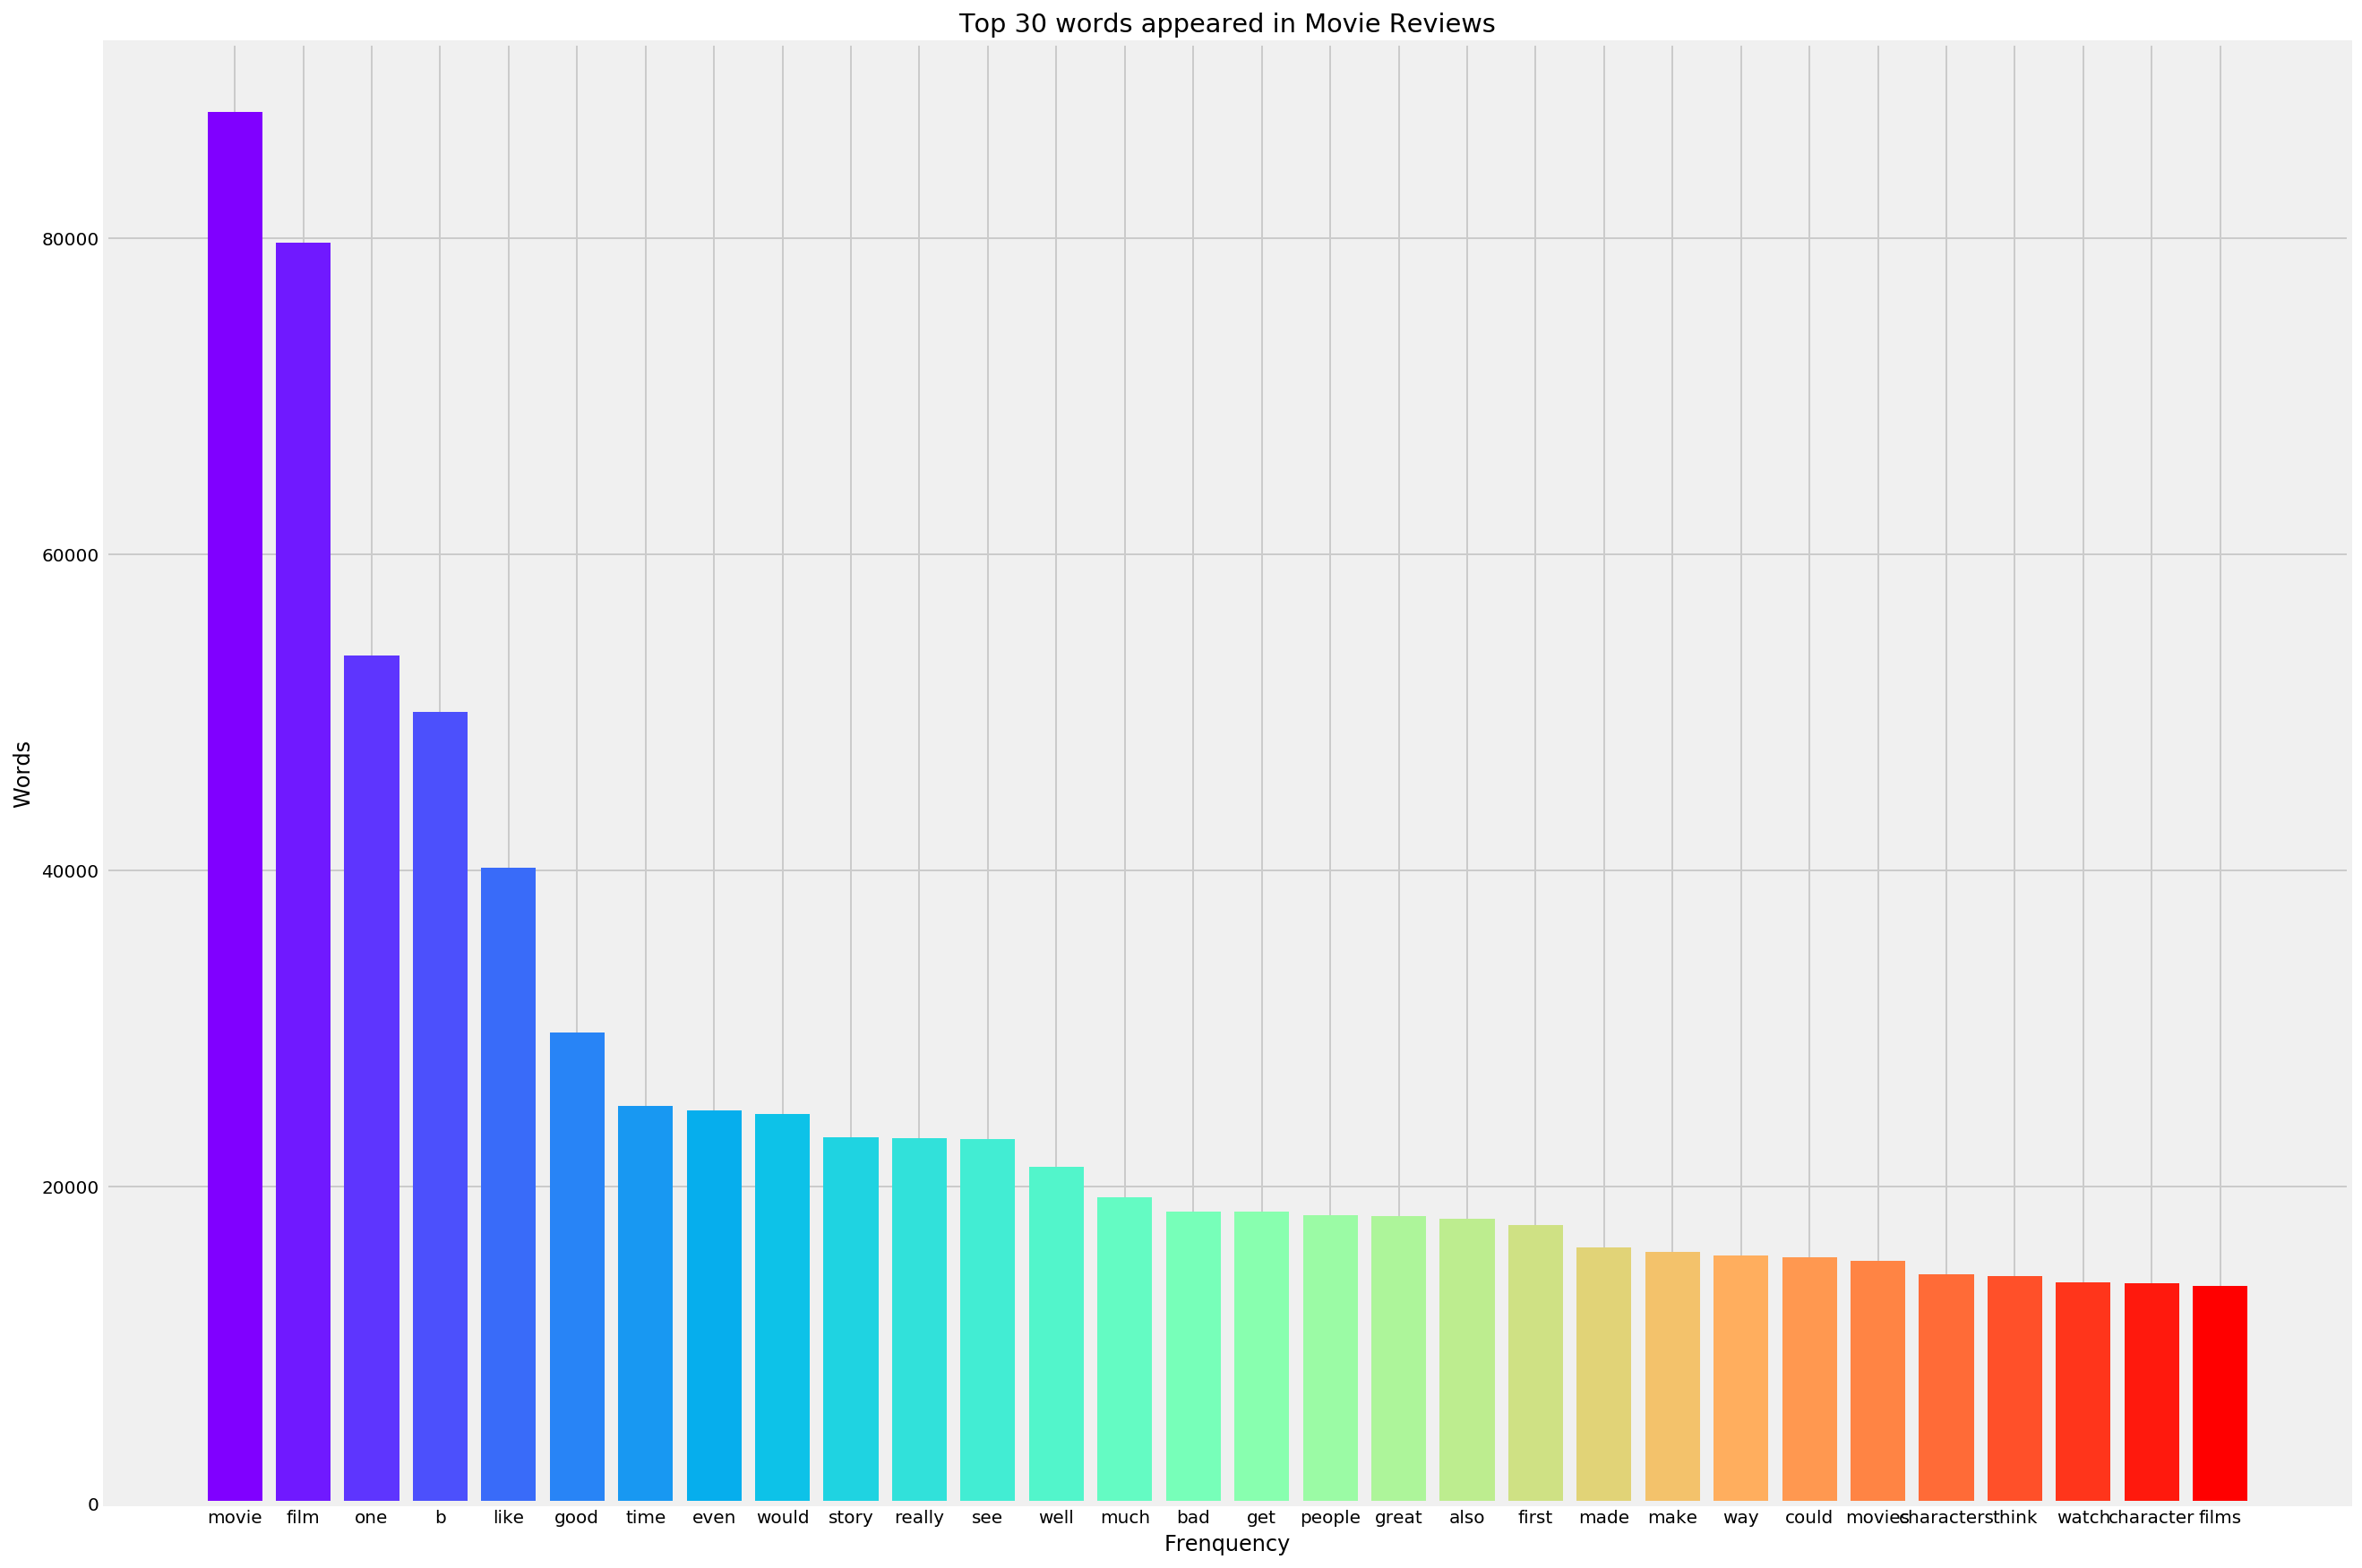

In [181]:
colors = cm.rainbow(np.linspace(0, 1, 30))
rcParams['figure.figsize'] = 20, 15
plt.title('Top 30 words appeared in Movie Reviews')
plt.xlabel('Frenquency')
plt.ylabel('Words')
plt.bar(words, counts,color=colors)

Features Extraction From the Reviews Text

In [182]:
wordvectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features =1000)

Preparing features for training and testing

In [183]:
unigramdataGet= wordvectorizer.fit_transform(WholeData['IMDB_Movie_Reviews'].astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = wordvectorizer.get_feature_names()
unigramdata=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
unigramdata[unigramdata>0] = 1
unigramdata.head()

,ability,able,absolutely,accent,act,acted,acting,action,actor,actors,...,wrong,wrote,yeah,year,years,yes,york,young,younger,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [184]:
print('Vocab Length ', len(vocab))


Vocab Length  1000


Deleteing the Reviews column because we have been extracted features from this

In [185]:
WholeData=WholeData.drop(columns='IMDB_Movie_Reviews')

Now Spliting data of Train and Test Accordingly for Training and Testing of Machine Learning Algorithms

In [186]:
X_train, X_test, Y_train, Y_test = train_test_split(unigramdata, WholeData['Class'], test_size=0.50)

Evaluation performance

In [235]:
from sklearn import metrics

In [236]:
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
                        

In [237]:
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)

#Random Forest

In [275]:
raf=RandomForestClassifier(min_samples_leaf=20, min_samples_split=20,random_state=100)
raf= raf.fit(X_train , Y_train)
raf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [276]:
Y_pred = raf.predict(X_test)
rf=raf.score(X_test, Y_test)
print('Accuracy score= {:.2f}'.format(raf.score(X_test, Y_test)))

Accuracy score= 0.82


In [277]:
print('\n')
print("Precision, Recall, F1")
print('\n')
print("Classification Report\n")
CR = classification_report(Y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.80      0.81     12470
    positive       0.81      0.83      0.82     12530

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000







confusion matrix


[[ 9979  2491]
 [ 2108 10422]]




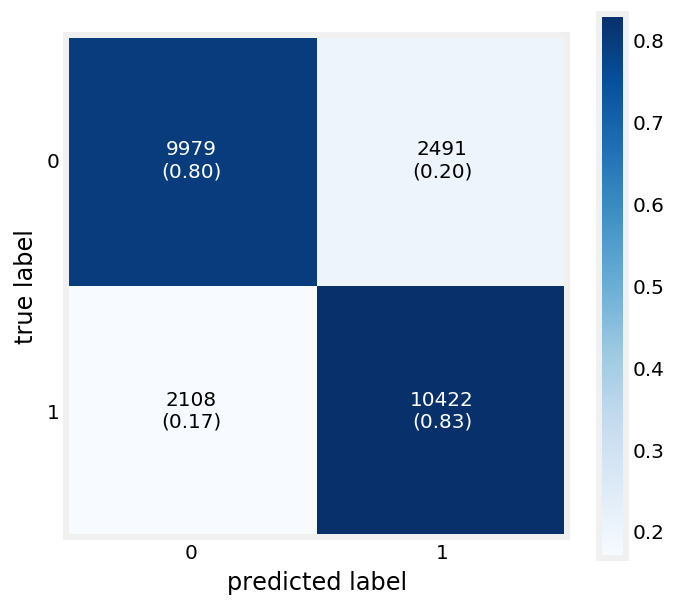

In [278]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, Y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                               colorbar=True)
plt.show()

In [298]:
display_model_performance_metrics(true_labels=Y_test, predicted_labels=Y_pred, target_names=['positive','negative'])

Model Performance metrics:
------------------------------
Accuracy:  81.60% 
Precision: 81.63% 
Recall:    81.60% 
F1 Score:  81.60% 


In [311]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y_test1 = Y_test
Y_test1 = labelencoder.fit_transform(Y_test1)
Y_test1

Y_pred1 = Y_pred
Y_pred1 = labelencoder.fit_transform(Y_pred1)
Y_pred1


array([0, 1, 0, ..., 0, 1, 1])

In [312]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test1, Y_pred1, pos_label=1)
print(metrics.auc(fpr, tpr))

0.8160021721725117


#Naive Bayes

In [313]:
nab=GaussianNB(var_smoothing=1e-09)
nab= nab.fit(X_train , Y_train)
nab

GaussianNB(priors=None, var_smoothing=1e-09)

In [314]:
Y_pred = nab.predict(X_test)
nb=nab.score(X_test, Y_test)
print('Accuracy score= {:.2f}'.format(nab.score(X_test, Y_test)))

Accuracy score= 0.82


In [315]:
print('\n')
print("Precision, Recall, F1")
print('\n')
print("Classification Report\n")
CR = classification_report(Y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


Classification Report

              precision    recall  f1-score   support

    negative       0.82      0.82      0.82     12470
    positive       0.82      0.82      0.82     12530

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000







confusion matrix


[[10201  2269]
 [ 2246 10284]]




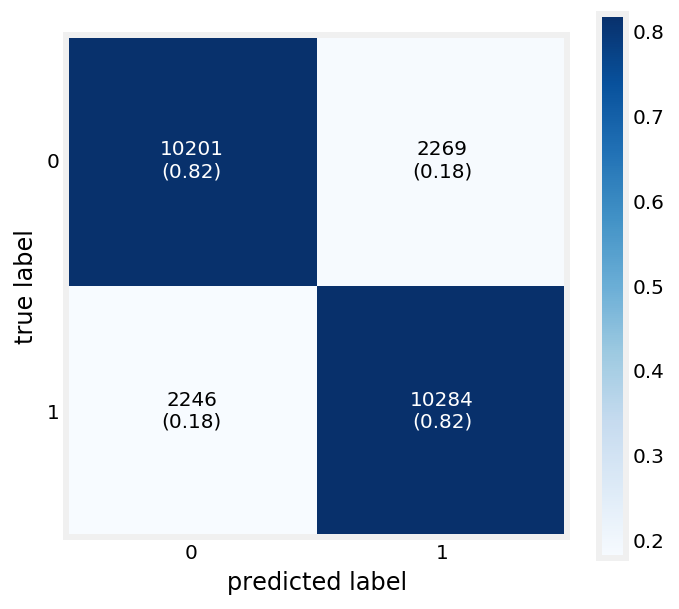

In [316]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, Y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [317]:
display_model_performance_metrics(true_labels=Y_test, predicted_labels=Y_pred, target_names=['positive','negative'])

Model Performance metrics:
------------------------------
Accuracy:  81.94% 
Precision: 81.94% 
Recall:    81.94% 
F1 Score:  81.94% 


In [318]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y_test1 = Y_test
Y_test1 = labelencoder.fit_transform(Y_test1)
Y_test1

Y_pred1 = Y_pred
Y_pred1 = labelencoder.fit_transform(Y_pred1)
Y_pred1


array([0, 1, 0, ..., 0, 1, 1])

In [319]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test1, Y_pred1, pos_label=1)
print(metrics.auc(fpr, tpr))

0.8193967517252899


#Multinomial Naive Bayes

In [320]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf = clf.fit(X_train, Y_train) #MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) #alpha->smoothing parameter(0 for no smoothing)
clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [321]:
Y_pred = clf.predict(X_test)
MNB=clf.score(X_test, Y_test)
print('Accuracy score= {:.2f}'.format(clf.score(X_test, Y_test)))

Accuracy score= 0.84


In [322]:
print('\n')
print("Precision, Recall, F1")
print('\n')
print("Classification Report\n")
CR = classification_report(Y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83     12470
    positive       0.83      0.85      0.84     12530

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000







confusion matrix


[[10293  2177]
 [ 1935 10595]]




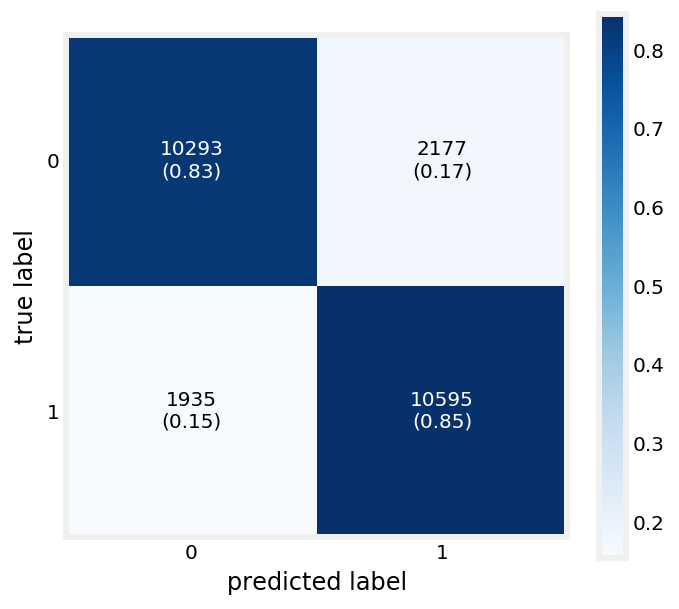

In [323]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, Y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [324]:
display_model_performance_metrics(true_labels=Y_test, predicted_labels=Y_pred, target_names=['positive','negative'])

Model Performance metrics:
------------------------------
Accuracy:  83.55% 
Precision: 83.56% 
Recall:    83.55% 
F1 Score:  83.55% 


In [325]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y_test1 = Y_test
Y_test1 = labelencoder.fit_transform(Y_test1)
Y_test1

Y_pred1 = Y_pred
Y_pred1 = labelencoder.fit_transform(Y_pred1)
Y_pred1
fpr, tpr, thresholds = metrics.roc_curve(Y_test1, Y_pred1, pos_label=1)
print(metrics.auc(fpr, tpr))

0.8354958204559257


#Logistic Regression

In [326]:
lor=LogisticRegression(C=0.05, max_iter=100)
lor= lor.fit(X_train , Y_train)
lor

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [327]:
Y_pred = lor.predict(X_test)
lr=lor.score(X_test, Y_test)
print('Accuracy score= {:.2f}'.format(lor.score(X_test, Y_test)))

Accuracy score= 0.85


In [328]:
print('\n')
print("Precision, Recall, F1")
print('\n')
print("Classification Report\n")
CR = classification_report(Y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.85      0.85     12470
    positive       0.85      0.86      0.85     12530

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000







confusion matrix


[[10548  1922]
 [ 1760 10770]]




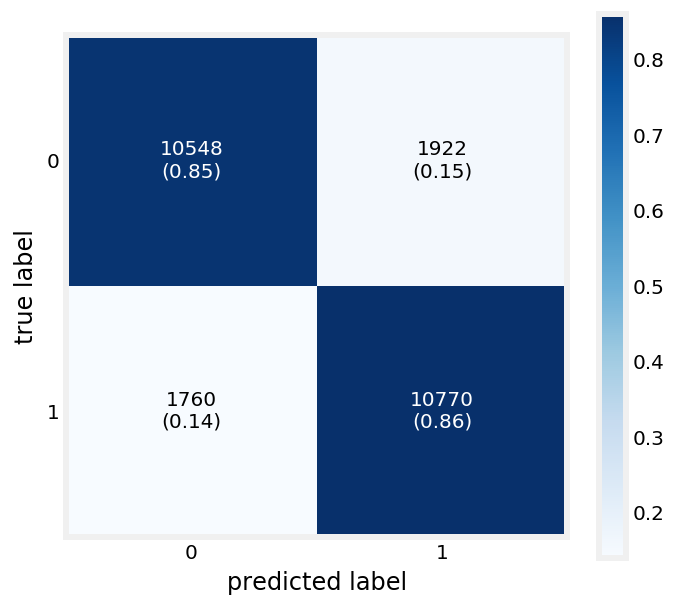

In [329]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, Y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [330]:
display_model_performance_metrics(true_labels=Y_test, predicted_labels=Y_pred, target_names=['positive','negative'])

Model Performance metrics:
------------------------------
Accuracy:  85.27% 
Precision: 85.28% 
Recall:    85.27% 
F1 Score:  85.27% 


In [331]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y_test1 = Y_test
Y_test1 = labelencoder.fit_transform(Y_test1)
Y_test1

Y_pred1 = Y_pred
Y_pred1 = labelencoder.fit_transform(Y_pred1)
Y_pred1
fpr, tpr, thresholds = metrics.roc_curve(Y_test1, Y_pred1, pos_label=1)
print(metrics.auc(fpr, tpr))

0.8527035995727336


#Support Vector Machine

In [332]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c, max_iter=500,loss='hinge')
    svm.fit(X_train, Y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(Y_test, svm.predict(X_test))))

Accuracy for C=0.01: 0.85156
Accuracy for C=0.05: 0.8504
Accuracy for C=0.25: 0.8476
Accuracy for C=0.5: 0.84688
Accuracy for C=1: 0.84676


Final SVM

In [333]:
svc=LinearSVC(C=0.01, max_iter=500,loss='hinge')
svc= svc.fit(X_train , Y_train)
svc

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=500, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [334]:
Y_pred=svc.predict(X_test)
svm=svc.score(X_test, Y_test)
print('Accuracy score= {:.2f}'.format(svc.score(X_test,Y_test)))

Accuracy score= 0.85


In [335]:
print('\n')
print("Precision, Recall, F1")
print('\n')
print("Classification Report\n")
CR = classification_report(Y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85     12470
    positive       0.84      0.87      0.85     12530

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000







confusion matrix


[[10415  2055]
 [ 1656 10874]]




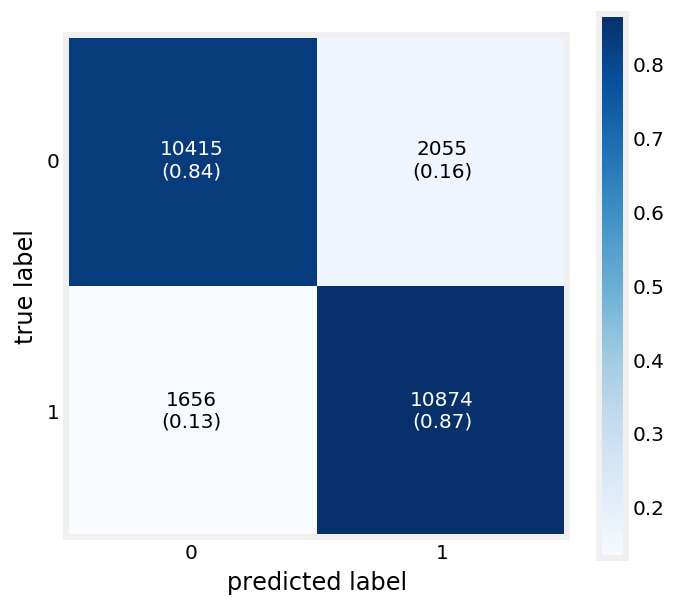

In [336]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, Y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [337]:
display_model_performance_metrics(true_labels=Y_test, predicted_labels=Y_pred, target_names=['positive','negative'])

Model Performance metrics:
------------------------------
Accuracy:  85.16% 
Precision: 85.19% 
Recall:    85.16% 
F1 Score:  85.15% 


In [338]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y_test1 = Y_test
Y_test1 = labelencoder.fit_transform(Y_test1)
Y_test1

Y_pred1 = Y_pred
Y_pred1 = labelencoder.fit_transform(Y_pred1)
Y_pred1
fpr, tpr, thresholds = metrics.roc_curve(Y_test1, Y_pred1, pos_label=1)
print(metrics.auc(fpr, tpr))

0.8515208407600426


#KNN

In [339]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 3)
KNN = KNN.fit(X_train, Y_train)
Y_pred = KNN.predict(X_test)


In [340]:
print('Accuracy score= {:.2f}'.format(KNN.score(X_test,Y_test)))

Accuracy score= 0.65


In [341]:
print('\n')
print("Precision, Recall, F1")
print('\n')
print("Classification Report\n")
CR = classification_report(Y_test, Y_pred)
print(CR)
print('\n')



Precision, Recall, F1


Classification Report

              precision    recall  f1-score   support

    negative       0.65      0.64      0.65     12470
    positive       0.65      0.66      0.65     12530

    accuracy                           0.65     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.65      0.65      0.65     25000







confusion matrix


[[7996 4474]
 [4256 8274]]




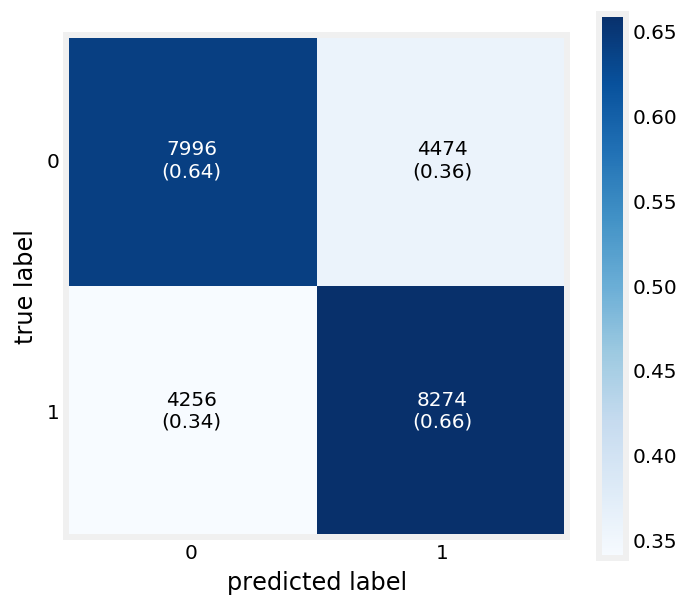

In [342]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, Y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [343]:
display_model_performance_metrics(true_labels=Y_test, predicted_labels=Y_pred, target_names=['positive','negative'])

Model Performance metrics:
------------------------------
Accuracy:  65.08% 
Precision: 65.08% 
Recall:    65.08% 
F1 Score:  65.08% 


In [344]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y_test1 = Y_test
Y_test1 = labelencoder.fit_transform(Y_test1)
Y_test1

Y_pred1 = Y_pred
Y_pred1 = labelencoder.fit_transform(Y_pred1)
Y_pred1
fpr, tpr, thresholds = metrics.roc_curve(Y_test1, Y_pred1, pos_label=1)
print(metrics.auc(fpr, tpr))

0.6507770604758683
